Useful references:

https://scikit-learn.org/stable/modules/svm.html

https://github.com/jakevdp/PythonDataScienceHandbook


# Support Vector Machines

Support vector machines (SVMs) are a particularly powerful and flexible class of *supervised algorithms for both classification and regression*.
In this section, we will develop the intuition behind support vector machines and their use in classification problems.

We begin with the standard imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Motivating Support Vector Machines

Consider the simple case of a classification task, in which the two classes of points are well separated:

C:\MY_SOFTS\DEV\IDE\MiniConda\envs\test\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


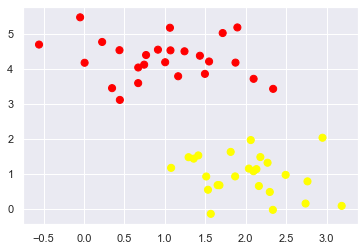

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.
For two dimensional data like that shown here, this is a task we could do by hand.
But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

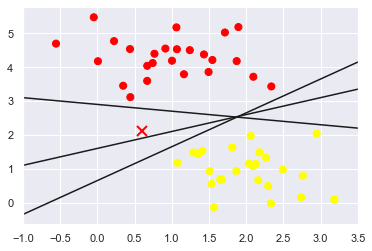

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## Support Vector Machines: Maximizing the *Margin*

Support vector machines offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.
Here is an example of how this might look:

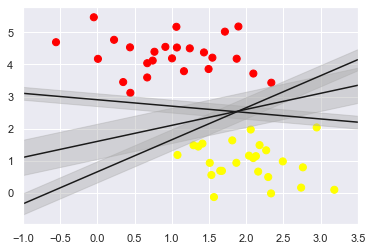

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.
Support vector machines are an example of such a *maximum margin* estimator.

### Fitting a support vector machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data.
For the time being, we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

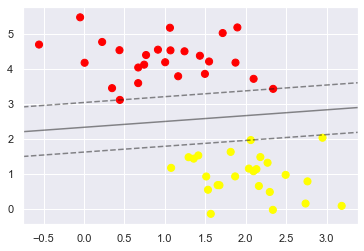

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure.
These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name.
In Scikit-Learn, the identity of these points are stored in the ``support_vectors_`` attribute of the classifier:

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit!
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

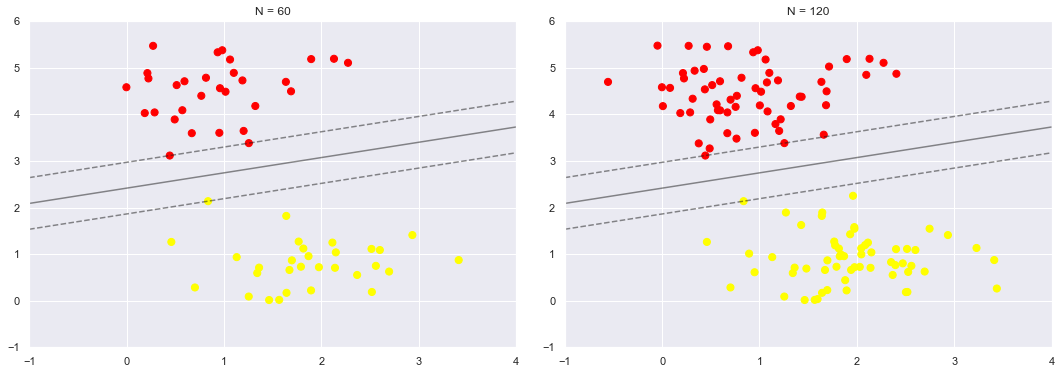

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel.
This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

If you are running this notebook live, you can use IPython's interactive widgets to view this feature of the SVM model interactively:

In [15]:
from ipywidgets import interact, fixed
interact(plot_svm, N=(10, 200, 5), ax=fixed(None));

interactive(children=(IntSlider(value=10, description='N', max=200, min=10, step=5), Output()), _dom_classes=(…

### Beyond linear boundaries: Kernel SVM

Where SVM becomes extremely powerful is when it is combined with *kernels*.

We will project our data into higher-dimensional space defined by polynomials and Gaussian basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier.

To motivate the need for kernels, let's look at some data that is not linearly separable:

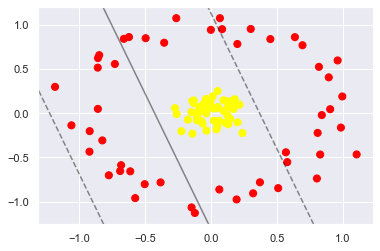

In [12]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will *ever* be able to separate this data.
But we can think about how we might project the data into a higher dimension such that a linear separator *would* be sufficient.
For example, one simple projection we could use would be to compute a *radial basis function* centered on the middle clump:

In [13]:
r = np.exp(-(X ** 2).sum(1))

We can visualize this extra data dimension using a three-dimensional plot—if you are running this notebook live, you will be able to use the sliders to rotate the plot:

In [16]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=(-90, 90), azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(IntSlider(value=30, description='elev', max=90, min=-90), IntSlider(value=30, descriptio…

We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, *r*=0.7.

Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results.
In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results.
This type of basis function transformation is known as a *kernel transformation*, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large.
However, because of a neat little procedure known as the [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection!
This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the ``kernel`` model hyperparameter:

In [17]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

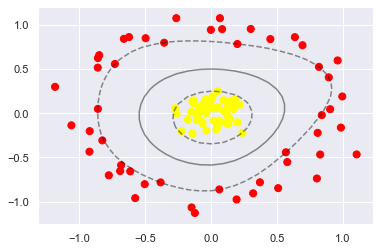

In [18]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.
This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

### Tuning the SVM: Softening Margins

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.
But what if your data has some amount of overlap?
For example, you may have data like this:

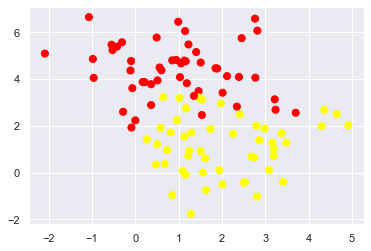

In [19]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.
The hardness of the margin is controlled by a tuning parameter, most often known as $C$.
For very large $C$, the margin is hard, and points cannot lie in it.
For smaller $C$, the margin is softer, and can grow to encompass some points.

The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

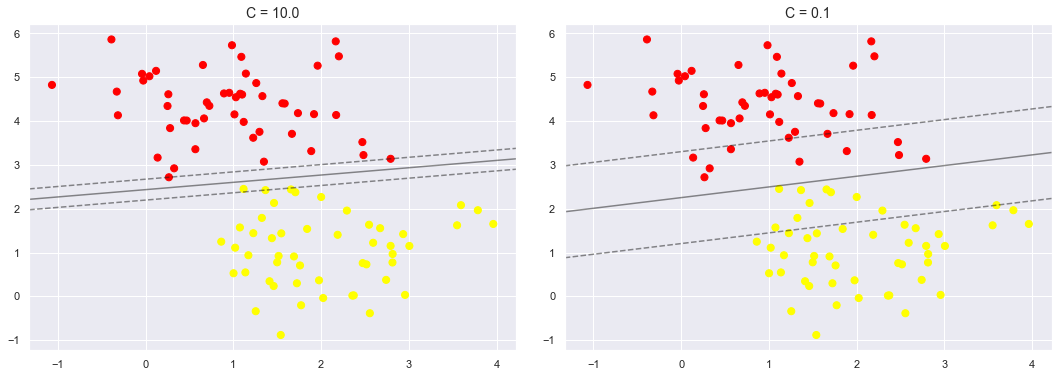

In [20]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure.

## Example: Face Recognition

As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

In [21]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's plot a few of these faces to see what we're working with:

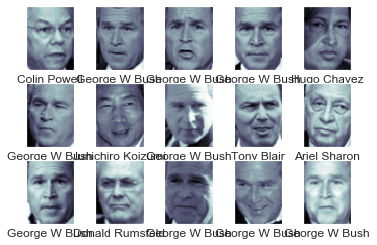

In [22]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Each image contains [62×47] or nearly 3,000 pixels.
We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis to extract 150 fundamental components to feed into our support vector machine classifier.
We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [23]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True, random_state=42, svd_solver='randomized')
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

For the sake of testing our classifier output, we will split the data into a training and testing set:

In [24]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Finally, we can use a grid search cross-validation to explore combinations of parameters.
Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model:

In [25]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

Wall time: 27.1 s
{'svc__C': 10, 'svc__gamma': 0.001}


The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen:

In [26]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Let's take a look at a few of the test images along with their predicted values:

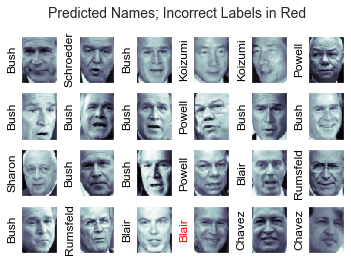

In [27]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s
face in the bottom row was mislabeled as Blair).
We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

In [28]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



We might also display the confusion matrix between these classes:

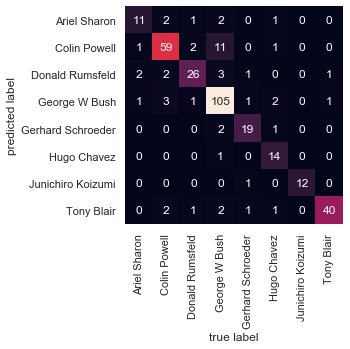

In [29]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

This helps us get a sense of which labels are likely to be confused by the estimator.

## Support Vector Machine Summary

We have seen here a brief intuitive introduction to the principals behind support vector machines.
These methods are a powerful classification method for a number of reasons:

- Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:

- The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter $C$. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the ``probability`` parameter of ``SVC``), but this extra estimation is costly.

We generally only turn to SVMs once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient for my needs.
Nevertheless, if you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.

# Exercises

Train an SVM model to do the recognition of hand-written digits. 
Follow the following points and answer the questions:
1. How many samples are there in the dataset? What size are the images? How mane pixels they contain?
2. Do you think it makes sense to use PCA here? Why or why not? Try to get the results with and without PCA
3. What is the best accuracy obtained by the SVM? Try different kernels (you can go to sklearn documentation to see different kernels)

In [30]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt 
%matplotlib inline

In [35]:
digits = load_digits()

In [39]:
# print(digits.DESCR)

<Figure size 432x288 with 0 Axes>

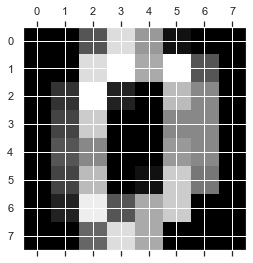

In [37]:
plt.gray() 
plt.matshow(digits.images[0]) 
plt.show() 

In [38]:
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [60]:
print(digits.target.shape)
print(digits.images.shape)
print(digits.data.shape)

(1797,)
(1797, 8, 8)
(1797, 64)


(array([178., 182., 177., 183., 181., 182., 181., 179., 174., 180.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

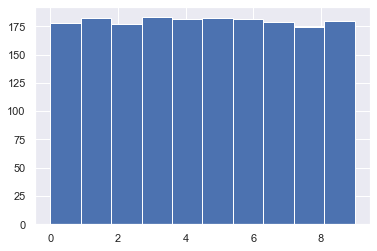

In [83]:
plt.hist(digits.target)

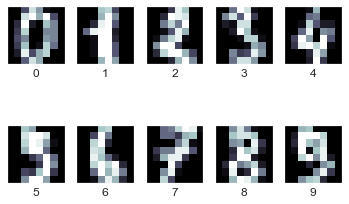

In [66]:
fig, ax = plt.subplots(2, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(digits.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=digits.target_names[digits.target[i]])

In [91]:
from sklearn.svm import SVC

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

svc = SVC(kernel='rbf', class_weight='balanced')

model = make_pipeline( svc)

from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target, random_state=42)

model.fit(Xtrain,ytrain)
accu = cross_val_score(model,Xtrain, ytrain,scoring='accuracy',cv=5)
accu

array([0.98148148, 0.98888889, 0.9739777 , 0.98513011, 0.98513011])

In [90]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

pca = PCA(n_components=0.95)
svc = SVC(kernel='rbf', class_weight='balanced')

model = make_pipeline(pca,svc)

from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target, random_state=42)

model.fit(Xtrain,ytrain)
accu = cross_val_score(model,Xtrain, ytrain,scoring='accuracy',cv=5)
print(accu)
pca.n_components_

[0.98518519 0.98888889 0.98884758 0.98884758 0.98141264]


28

In [92]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

Wall time: 6.82 s
{'svc__C': 1, 'svc__gamma': 0.001}


In [93]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

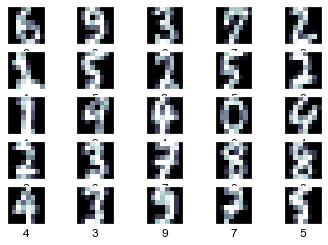

In [94]:
fig, ax = plt.subplots(5, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(8, 8), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(digits.target_names[yfit[i]],
                   color='black' if yfit[i] == ytest[i] else 'red')
# fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

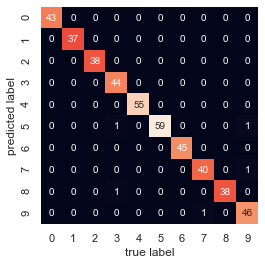

In [95]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [105]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        37
           2       1.00      1.00      1.00        38
           3       1.00      0.96      0.98        46
           4       1.00      1.00      1.00        55
           5       0.97      1.00      0.98        59
           6       1.00      1.00      1.00        45
           7       0.98      0.98      0.98        41
           8       0.97      1.00      0.99        38
           9       0.98      0.96      0.97        48

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



# Convolutional Neural Networks  (CNN)

Deep Neural Networks are composed of complex and many number of hidden layers which tries to extract low level features from the images. Some examples of complex deep neural networks are Convolutional Neural Networks (CNN) and Recurrent Neural Networks (RNN). 


In Convolutional Neural Networks, every image input is treated as a a matrix of pixel values which represents the amount of darkness at a given pixel in the image. Unlike, tradational neural networks which treats an image as a one dimentional network, CNNs considers the location of pixels and the neighbours for classification.

<br>

![](http://www.mdpi.com/information/information-07-00061/article_deploy/html/images/information-07-00061-g001.png)

<br>

### Key components of Convolutional Neural Network. 

**A. Convolutional layer: ** In this layer, a kernel (or weight) matrix is used to extract low level features from the images. The kernel with its weights rotates over the image matrix in a sliding window fashion in order to obtained the convolved output. The kernel matrix behaves like a filter in an image extracting particular information from the original image matrix. During the colvolution process, The weights are learnt such that the loss function is minimized.

**B. Stride: ** Stride is defined as the number of steps the kernel or the weight matrix takes while moving across the entire image moving N pixel at a time. If the weight matrix moves N pixel at a time, it is called stride of N.

![](http://deeplearning.net/software/theano/_images/numerical_padding_strides.gif) 
Image Credits - www.deeplearning.net

**C. Pooling Layer:**  Pooling layers are used to extract the most informative features from the generated convolved output. 

![](https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png)

**D. Output Layer:** To generate the final output, a dense or a fully connected layer is applied with the softmax activation function. Softmax function is used to generate the probabilities for each class of the target variable. 

<br>


In [106]:
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.images, faces.target,
                                                random_state=42)

In [107]:
# network parameters 
batch_size = 128
num_classes = 10
epochs = 50

### Preprocess the Inputs

In the preprocessing step the corresponding image data vectors are reshaped into a 4 dimentional vector : total batch size, width of the image, height of the image, and the channel. In our case, channel = 1 as we will only use single channel instead of three channels (R,G,B). The next step is to resize the inputs and normalize them by dividing them by max pixel value ie. 255. 

In [108]:
import cv2
import keras

Using TensorFlow backend.


In [109]:
Xtrain.shape

(1011, 62, 47)

In [110]:
#resize_size = (62,47)
resize_size = (64,64)

In [111]:
Xtrain_resized = [cv2.resize(img, resize_size) for img in Xtrain]
Xtest_resized = [cv2.resize(img, resize_size) for img in Xtest]

In [112]:
Xtrain_resized = np.array(Xtrain_resized).astype('float32')
Xtrain_resized /= 255

Xtest_resized = np.array(Xtest_resized).astype('float32')
Xtest_resized /= 255

In [113]:
# convert the target variable 
ytrain_cat = keras.utils.to_categorical(ytrain, num_classes)
ytest_cat = keras.utils.to_categorical(ytest, num_classes)

# specify the channel = 1
Xtrain_resized = Xtrain_resized.reshape(Xtrain_resized.shape[0], Xtrain_resized.shape[1], Xtrain_resized.shape[2], 1)
Xtest_resized = Xtest_resized.reshape(Xtest_resized.shape[0], Xtest_resized.shape[1], Xtest_resized.shape[2], 1)

Create the CNN Model Architecture

In this step, create the convolutional neural network architecture with following layers: 

1. Convolutional Layer with kernel size = 3*3, 32 convolutional units, and RelU activation function 
2. Convolutional Layer with kernel size = 3*3, 64 convolutional units, and RelU activation function  
3. Max Pooling Layer with pooling matrix size = 2*2
4. Dropout Layer : A dropout layer is used for regularization and reducing the overfitting 
5. Flatten Layer : A layer to convert the output in one dimentional array
6. Dense Layer : A dense layer is a fully connected layer in which every node is connected to every other node in the previous and next layers. In our network, it contains 128 neurons but this number can be changed for further experiments. 
7. Another Dropout Layer for regularization 
8. Final output layer : A dense layer with 10 neurons for generating the output class 

In the simple neural network that we implemented in step 1, the loss function was LogLoss function and the optimizing Algorithm was Gradient Descent, In this neural network, we will use categorical_crossentropy as this is a multi class classification as the loss function and SGD as the optimizing function. 

In [114]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential

In [115]:
input_shape = Xtrain_resized.shape[1:]

In [116]:
model = Sequential()

# add first convolutional layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))

# add second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))

# add one max pooling layer 
model.add(MaxPooling2D(pool_size=(2, 2)))

# add one dropout layer
model.add(Dropout(0.125))

# add flatten layer
model.add(Flatten())

# add dense layer
model.add(Dense(128, activation='relu'))

# add another dropout layer
model.add(Dropout(0.25))

# add dense layer
model.add(Dense(num_classes, activation='softmax'))

# complile the model and view its architecur
model.compile(loss=keras.losses.categorical_crossentropy,  optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               7372928   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [118]:
history = model.fit(Xtrain_resized, ytrain_cat, 
          batch_size=batch_size, 
          epochs=epochs, 
          verbose=1, 
          validation_data=(Xtest_resized, ytest_cat))
accuracy = model.evaluate(Xtest_resized, ytest_cat, verbose=0)
print('Test accuracy:', accuracy[1])

Train on 1011 samples, validate on 337 samples
Epoch 1/50
1011/1011 [==============================] - 1s 742us/step - loss: 0.1556 - accuracy: 0.9535 - val_loss: 0.5305 - val_accuracy: 0.8665
Epoch 2/50
1011/1011 [==============================] - 1s 706us/step - loss: 0.1338 - accuracy: 0.9585 - val_loss: 0.4739 - val_accuracy: 0.8754
Epoch 3/50
1011/1011 [==============================] - 1s 714us/step - loss: 0.1285 - accuracy: 0.9614 - val_loss: 0.4968 - val_accuracy: 0.8665
Epoch 4/50
1011/1011 [==============================] - 1s 714us/step - loss: 0.1353 - accuracy: 0.9565 - val_loss: 0.4786 - val_accuracy: 0.8783
Epoch 5/50
1011/1011 [==============================] - 1s 712us/step - loss: 0.2493 - accuracy: 0.9189 - val_loss: 0.5722 - val_accuracy: 0.8309
Epoch 6/50
1011/1011 [==============================] - 1s 712us/step - loss: 0.1200 - accuracy: 0.9683 - val_loss: 0.4988 - val_accuracy: 0.8783
Epoch 7/50
1011/1011 [==============================] - 1s 713us/step - loss:

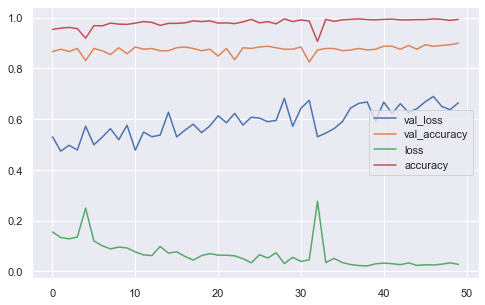

In [119]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca()
plt.show()

# Exercises

Build your CNN for digits dataset. Experiment with number of kernels/neurons in layers. What is the best accuracy you can obtain?
Try different learning rate, batch size, number of epochs

In [184]:
from sklearn.datasets import load_digits
digits = load_digits()

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(digits.data, digits.target, random_state=42)

In [185]:
xtrain /= 255.
xtest /= 255.

In [186]:
xtrain = xtrain.reshape(len(xtrain),8,8,1)
xtest = xtest.reshape(len(xtest),8,8,1)
xtrain.shape

(1347, 8, 8, 1)

In [187]:
num_classes = len(np.unique(ytrain))
num_classes

10

In [188]:
ytrain_cat = keras.utils.to_categorical(ytrain, num_classes)
ytest_cat = keras.utils.to_categorical(ytest, num_classes)

In [219]:
from keras.backend import clear_session

clear_session()
model = None

In [220]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',padding='same', input_shape=(8,8,1)))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.125))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,  optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 8, 8, 32)          320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

In [221]:
BS = 128
EPOCH = 50

history = model.fit(xtrain, ytrain_cat, 
          batch_size=BS, 
          epochs=EPOCH, 
          verbose=1, 
          validation_data=(xtest, ytest_cat))
accuracy = model.evaluate(xtest, ytest_cat, verbose=0)
print('Test accuracy:', accuracy[1])

Train on 1347 samples, validate on 450 samples
Epoch 1/50
1347/1347 [==============================] - 0s 256us/step - loss: 2.3012 - accuracy: 0.1002 - val_loss: 2.3006 - val_accuracy: 0.0822
Epoch 2/50
1347/1347 [==============================] - 0s 88us/step - loss: 2.2961 - accuracy: 0.1299 - val_loss: 2.2945 - val_accuracy: 0.0822
Epoch 3/50
1347/1347 [==============================] - 0s 85us/step - loss: 2.2837 - accuracy: 0.1240 - val_loss: 2.2757 - val_accuracy: 0.2467
Epoch 4/50
1347/1347 [==============================] - 0s 85us/step - loss: 2.2346 - accuracy: 0.2108 - val_loss: 2.1662 - val_accuracy: 0.2311
Epoch 5/50
1347/1347 [==============================] - 0s 81us/step - loss: 1.9880 - accuracy: 0.3311 - val_loss: 2.0048 - val_accuracy: 0.3333
Epoch 6/50
1347/1347 [==============================] - 0s 82us/step - loss: 1.4781 - accuracy: 0.5316 - val_loss: 1.1356 - val_accuracy: 0.5733
Epoch 7/50
1347/1347 [==============================] - 0s 82us/step - loss: 1.037

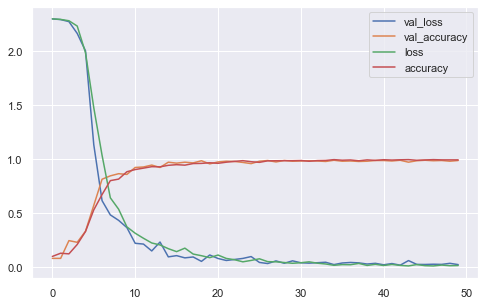

In [225]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()